# DLProfile Example using Imagenet Application

## Set imports and neccessary environment variables

In [1]:
import pathlib
import os
import sys
import matplotlib.pyplot as plt
import warnings
import pprint
import pandas as pd
import tensorflow as tf
import ntpath
import numpy as np
import math

In [2]:
VANIDL_DIR="{}".format(pathlib.Path(os.getcwd()).parent.parent.parent.absolute())
sys.path.insert(0, VANIDL_DIR)
warnings.filterwarnings('ignore')

In [3]:
os.environ["DARSHAN_DIR"] = "/soft/perftools/darshan/darshan-3.1.8"
os.environ["VANIDL_DIR"] = VANIDL_DIR

### Formatting

In [4]:
pp = pprint.PrettyPrinter(indent=1)
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Create instrance of DL Profile and load the darshan file

In [5]:
from src.vanidl import VaniDL
profile = VaniDL()

In [6]:
import shutil
shutil.rmtree('/tmp/temp_analysis')

In [7]:
DATAPATH_INCLUDES = []
status = profile.Load("/home/dhari/darshan-logs/apps/imagenet/imagenet_run1_p8.darshan", data_paths_include=DATAPATH_INCLUDES)
if status:
    print("Darshan Trace loaded Successfully!")
else:
    print("Darshan Trace load Failed!")
    print(profile._error_str())

[============================================================] 100.0% 53279 of 53279 Parsing DXT File 
[============================================================] 100.0% 95919 of 95919 Parsing Darshan File 
Darshan Trace loaded Successfully!


## Use Profile object to analyze the darshan I/O trace.

### Verify if object works

The GetDXTAsDF() function enables users to perform analysis 

In [8]:
pd.set_option('display.max_colwidth', -1)
df = profile.GetDXTAsDF()
pp.pprint("Number of Files used in the application: {} files".format(df['Filename'].nunique()))

'Number of Files used in the application: 276 files'


### Collect the summary of the Application

In [9]:
summary = profile.GetSummary()
print("\n")
print(color.BOLD + "Data Access Summary (from Darshan):"+ color.END)
print("Total Job time\t\t\t:\t{:0.2f} seconds".format(summary['job_time']))
#FIXME: calculate time per rank and then take max across it.
print("Time spent in I/O\t\t:\t{:0.2f} seconds".format(summary['total_io_time']))
print("% Time spent in I/O\t\t:\t{:0.2f}%".format(float(summary['total_io_time'])*100/summary['job_time']))
print("Total Data Accessed\t\t:\t{:0.2f} GB".format(float(summary['total_io_bytes'])/1024.0/1024.0/1024.0))
print("Data Access Modules used\t:\t{}".format(summary['io_interface_used']))
print("Data Operations\t\t\t:\t{}".format(summary['io_operations_used']))
print("# of files used\t\t\t:\t{}".format(len(summary['files_used'])))
print("# of MPI Ranks\t\t\t:\t{:0.0f} ranks".format(summary['num_ranks']))
      
print(color.UNDERLINE + "Data Transfer size:"+ color.END)
print("\tMin,Max\t\t\t:\t{:0.0f} bytes and {:0.0f} bytes".format(summary['data_transfer_size']['min'],summary['data_transfer_size']['max']))
print("\tAverage\t\t\t:\t{:0.0f} bytes".format(summary['data_transfer_size']['mean']))
print("\tMedian\t\t\t:\t{:0.0f} bytes".format(summary['data_transfer_size']['median']))
      
print(color.UNDERLINE + "Data Transfer bandwidth: (per rank)"+ color.END)
print("\tMin,Max\t\t\t:\t{:0.0f} B/s and {:0.0f} MB/s".format(summary['data_transfer_bandwidth']['min'],summary['data_transfer_bandwidth']['max']/1024.0/1024.0))
print("\tAverage\t\t\t:\t{:0.0f} MB/s".format(summary['data_transfer_bandwidth']['mean']/1024.0/1024.0))
print("\tMedian\t\t\t:\t{:0.0f} MB/s".format(summary['data_transfer_bandwidth']['median']/1024.0/1024.0))
      
print(color.UNDERLINE + "Access Pattern:"+ color.END)
print("\tSequential\t\t:\t{:0.2f}%".format(float(summary['access_pattern']['sequential'])))
print("\tConsecutive\t\t:\t{:0.2f}%".format(float(summary['access_pattern']['consecutive'])))
#An I/O op issued at an offset greater than where the previous I/O op ended.
#An I/O op issued at the offset immediately after the end of the previous I/O

print("\n")
print(color.BOLD + "Files Summary:"+ color.END)
print("File Types\t\t\t:\t{}".format("tfrecord"))
print(color.UNDERLINE + "Dataset Size:"+ color.END)
print("\tTotal\t\t\t:\t{:0.3f} GB".format(float(summary['file_used_summary']['size']['total'])/1024.0/1024.0/1024.0))
print("\tMin,Max\t\t\t:\t{:0.3f} GB and {:0.3f} GB".format(float(summary['file_used_summary']['size']['min'])/1024.0/1024.0/1024.0,float(summary['file_used_summary']['size']['max'])/1024.0/1024.0/1024.0))
print("\tAverage\t\t\t:\t{:0.3f} GB".format(float(summary['file_used_summary']['size']['mean'])/1024.0/1024.0/1024.0))



Data Access Summary (from Darshan):
Total Job time			:	1444.00 seconds
Time spent in I/O		:	29.43 seconds
% Time spent in I/O		:	2.04%
Total Data Accessed		:	12.09 GB
Data Access Modules used	:	['X_POSIX']
Data Operations			:	['read']
# of files used			:	276
# of MPI Ranks			:	8 ranks
Data Transfer size:
	Min,Max			:	0 bytes and 262144 bytes
	Average			:	261062 bytes
	Median			:	262144 bytes
Data Transfer bandwidth: (per rank)
	Min,Max			:	0 B/s and 2500 MB/s
	Average			:	880 MB/s
	Median			:	833 MB/s
Access Pattern:
	Sequential		:	99.36%
	Consecutive		:	99.36%


Files Summary:
File Types			:	tfrecord
Dataset Size:
	Total			:	131.964 GB
	Min,Max			:	0.037 GB and 0.151 GB
	Average			:	0.134 GB


In [10]:
pp.pprint("Job time : {} seconds".format(profile.GetJobTime()))

'Job time : 1444.0 seconds'


In [11]:
pp.pprint("Time spent by application on I/O: {} seconds".format(profile.GetIOTime()))

'Time spent by application on I/O: 29.4283125000001 seconds'


### I/O time spent on each file

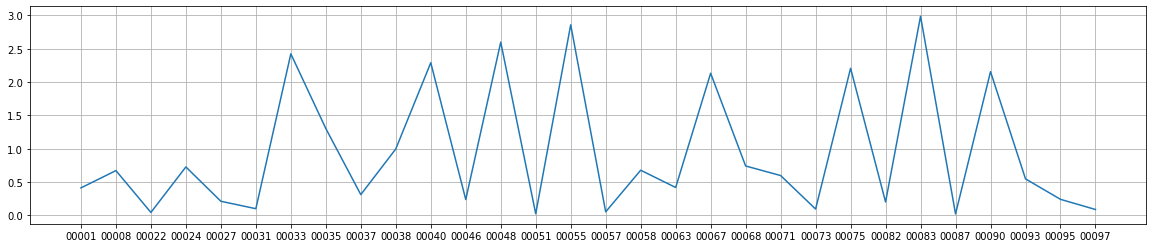

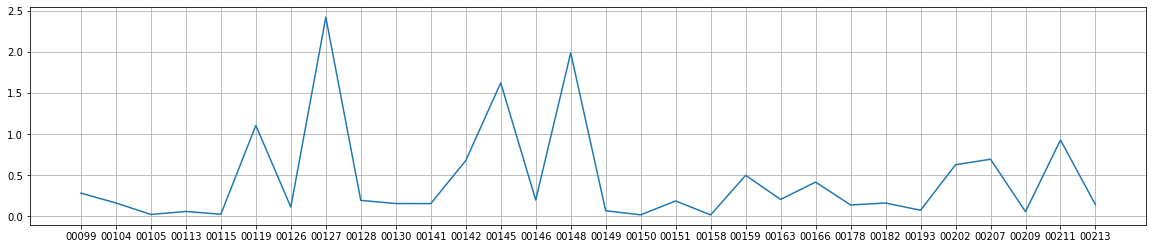

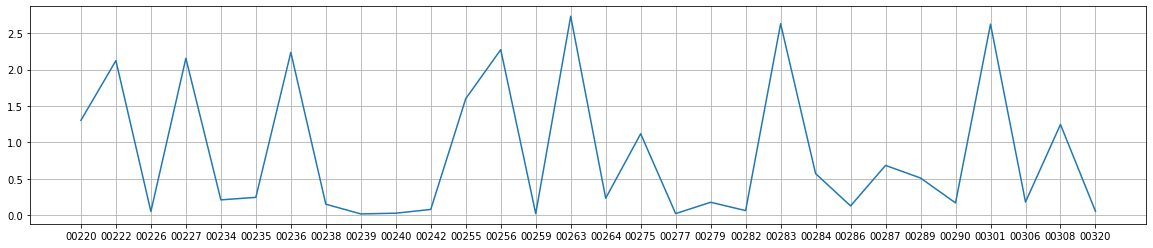

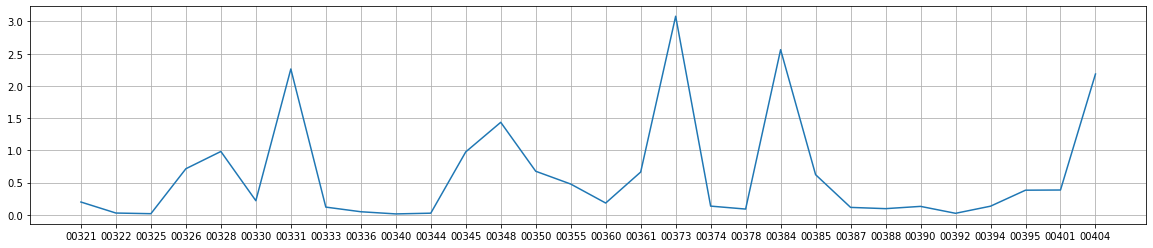

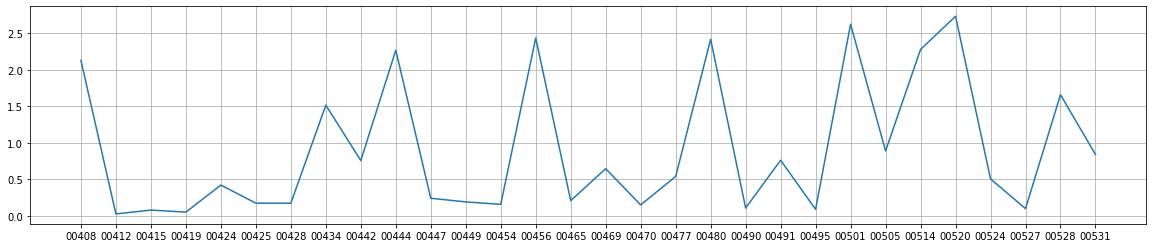

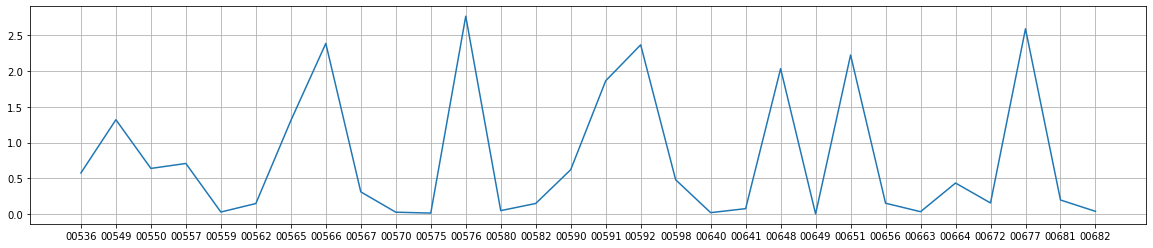

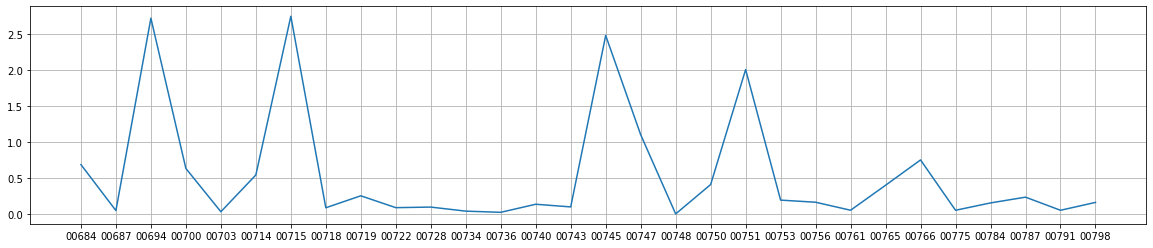

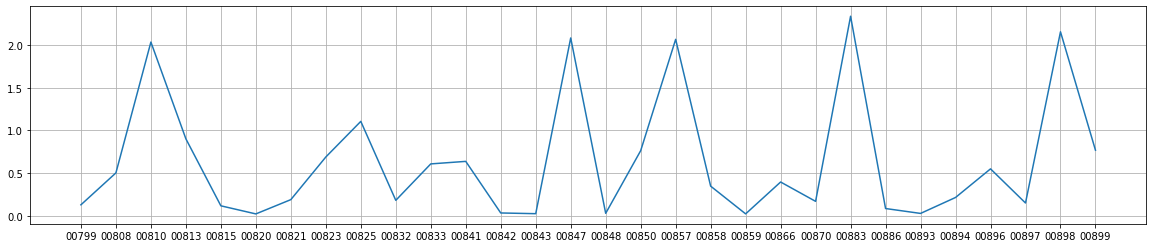

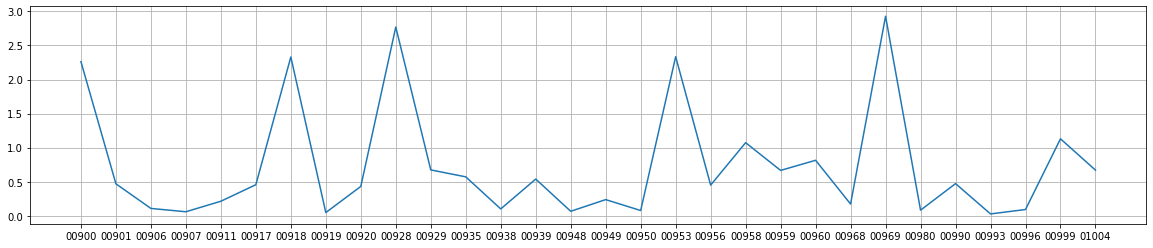

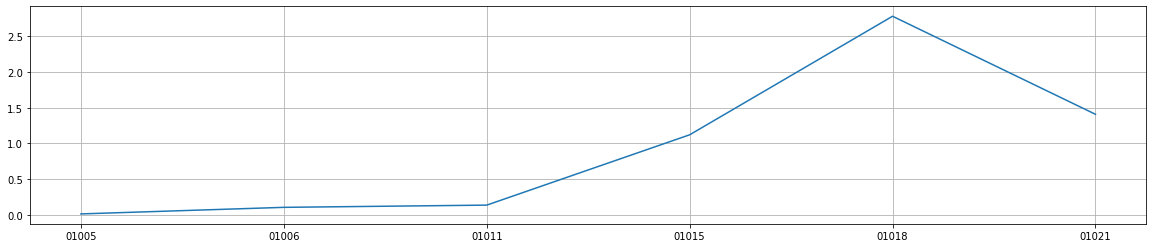

In [12]:
filename_series = []
time_series = []
for file in df['Filename'].unique():
    filename_series.append(os.path.splitext(ntpath.basename(file))[0][6:11])
    time_series.append(profile.GetIOTime(filepath=file))

zipped_lists = zip(filename_series, time_series)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
filename_series, time_series = [ list(tuple) for tuple in  tuples]
points_x = 30
for i in range(math.ceil(float(len(time_series))/points_x)):
    start = i * points_x
    end = (i+1) * points_x
    plt.figure(figsize=(20,4))
    plt.grid()
    plt.plot(filename_series[start:end], time_series[start:end]);
    plt.show()

### I/O Time spent per rank

In [13]:
for rank in df['Rank'].unique():
    print("I/O time for rank {}: {:0.2f} seconds".format(rank,profile.GetIOTime(rank=rank)))

I/O time for rank 0: 35.67 seconds
I/O time for rank 1: 26.43 seconds
I/O time for rank 2: 31.65 seconds
I/O time for rank 3: 28.64 seconds
I/O time for rank 4: 25.40 seconds
I/O time for rank 5: 28.62 seconds
I/O time for rank 6: 27.39 seconds
I/O time for rank 7: 31.62 seconds


In [14]:
"Total I/O performed by application: {:0.2f} GB".format(float(profile.GetIOSize())/1024.0/1024.0/1024.0)

'Total I/O performed by application: 12.09 GB'

### I/O performed on each file

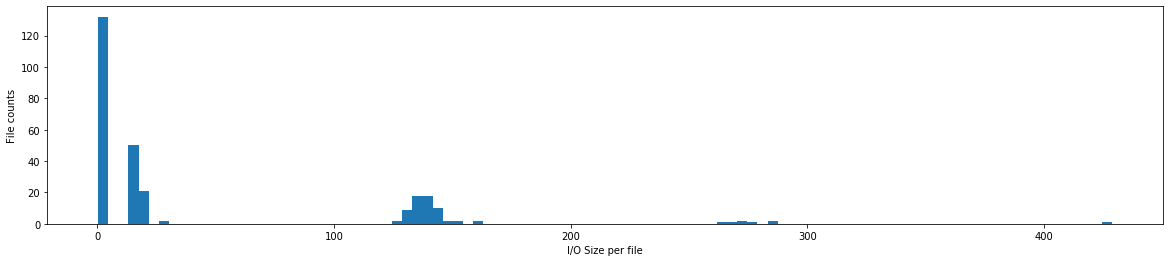

In [15]:
filename_series = []
size_series = []
for file in df['Filename'].unique():
    filename_series.append(os.path.splitext(ntpath.basename(file))[0][6:11])
    size_series.append(float(profile.GetIOSize(filepath=file))/1024.0/1024.0)

zipped_lists = zip(filename_series, size_series)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
filename_series, size_series = [ list(tuple) for tuple in  tuples]



plt.figure(figsize=(20,4))
size_series = np.array(size_series)
plt.hist(size_series,bins = 100)
plt.xlabel("I/O Size per file")
plt.ylabel("File counts")
plt.show()
    
# points_x = 30
# for i in range(math.ceil(float(len(size_series))/points_x)):
#     start = i * points_x
#     end = (i+1) * points_x
#     plt.figure(figsize=(20,4))
#     plt.grid()
#     plt.plot(filename_series[start:end], size_series[start:end]);
#     plt.show()

In [16]:
for rank in df['Rank'].unique():
    print("I/O performed by rank {}: {:0.2f} MB".format(rank, float(profile.GetIOSize(rank=rank))/1024.0/1024.0))

I/O performed by rank 0: 1512.34 MB
I/O performed by rank 1: 1524.77 MB
I/O performed by rank 2: 1552.49 MB
I/O performed by rank 3: 1560.19 MB
I/O performed by rank 4: 1545.73 MB
I/O performed by rank 5: 1552.50 MB
I/O performed by rank 6: 1565.04 MB
I/O performed by rank 7: 1563.91 MB


In [17]:
print("Average Size of dataset {:0.2f} MB".format(np.mean(list(profile.GetFileSizes().values()))/1024.0/1024.0))

Average Size of dataset 137.33 MB


### How application access data over time.

[============================================================] 100.0% 49713 of 49713 Creating Timeline 


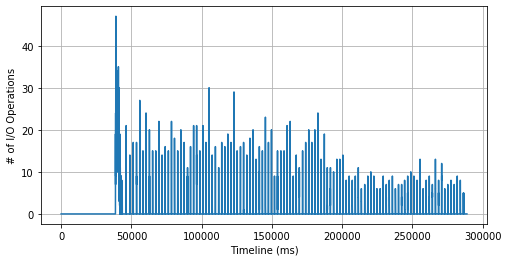

In [18]:
tl = profile.CreateIOTimeline(is_print=False)
plt.figure(figsize=(8,4))
plt.xlabel("Timeline (ms)")
plt.ylabel("# of I/O Operations")
plt.grid()
plt.plot(tl['time_step'], tl['operation_count']);

# plt.figure(figsize=(20,4))
plt.grid()
plt.plot(tl['time_step'], tl['io_bytes']);

### How files are accessed over the duration of the Job.

[============================================================] 100.0% 538 of 538 Creating Timeline 
[============================================================] 100.0% 65 of 65 Creating Timeline 
[============================================================] 100.0% 524 of 524 Creating Timeline 
[============================================================] 100.0% 531 of 531 Creating Timeline 
[============================================================] 100.0% 577 of 577 Creating Timeline 
[============================================================] 100.0% 561 of 561 Creating Timeline 
[============================================================] 100.0% 533 of 533 Creating Timeline 
[============================================================] 100.0% 535 of 535 Creating Timeline 


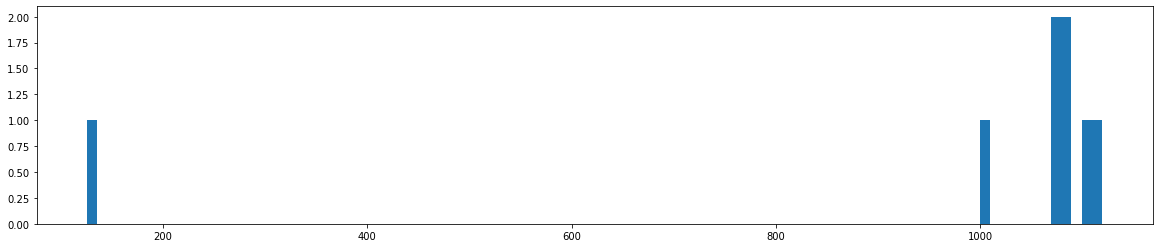

In [19]:
filename_series = []
operation_series = []
for file in df['Filename'].unique()[:8]:
    tl = profile.CreateIOTimeline(filepath=file,is_print=False,save=False)
    filename_series.append(os.path.splitext(ntpath.basename(file))[0][6:11])
    operation_series.append(tl['operation_count'].sum())

plt.figure(figsize=(20,4))
operation_series = np.array(operation_series)
plt.hist(operation_series,bins = 100);
plt.show()

### Show how each file is accessed by each rank.

[============================================================] 100.0% 6074 of 6074 Creating Timeline 


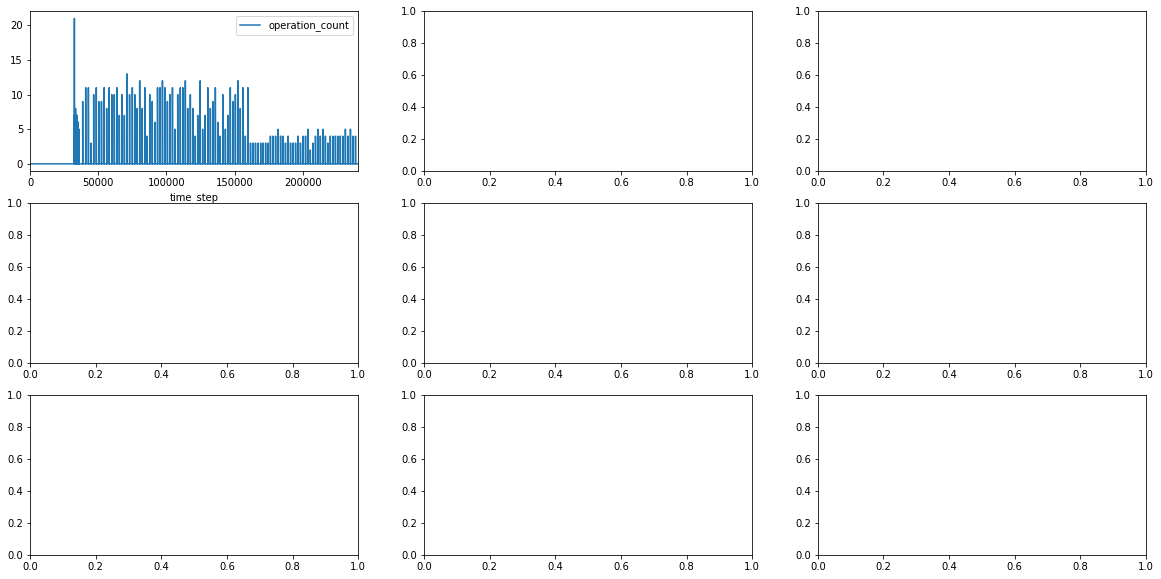

[============================================================] 100.0% 6125 of 6125 Creating Timeline 
[============================================================] 100.0% 6236 of 6236 Creating Timeline 
[============================================================] 100.0% 6267 of 6267 Creating Timeline 
[============================================================] 100.0% 6208 of 6208 Creating Timeline 
[============================================================] 100.0% 6236 of 6236 Creating Timeline 
[============================================================] 100.0% 6285 of 6285 Creating Timeline 
[============================================================] 100.0% 6282 of 6282 Creating Timeline 


In [20]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for rank in df['Rank'].unique()[:8]:
    x = int(rank/3)
    y = rank%3
    tl = profile.CreateIOTimeline(rank=rank,save=False)
    tl.plot(x='time_step',y='operation_count', title=rank, ax=axs[x][y])
    plt.show()

### Data Transfer Size distribution within the application

Text(0.5, 0, 'Transfer Size in bytes')

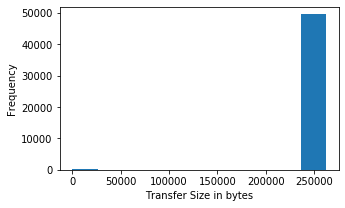

In [21]:
request_df = profile.GetIORequestDistribution()
df['Length'].plot(kind='hist', figsize=(5, 3));
plt.xlabel("Transfer Size in bytes")

### Data Transfer Size distribution for each file.

In [22]:
filename_series = []
request_mean = []
for file in df['Filename'].unique()[:8]:
    tl = profile.GetIORequestDistribution(filepath=file)
    request_mean.append(tl.mean())

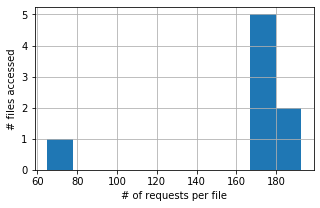

In [23]:
plt.figure(figsize=(5,3))
request_mean = np.array(request_mean)
plt.hist(request_mean,bins = 10);
plt.ylabel("# files accessed")
plt.xlabel("# of requests per file")
plt.grid()
plt.show()

### Data Transfer Sizes per Rank

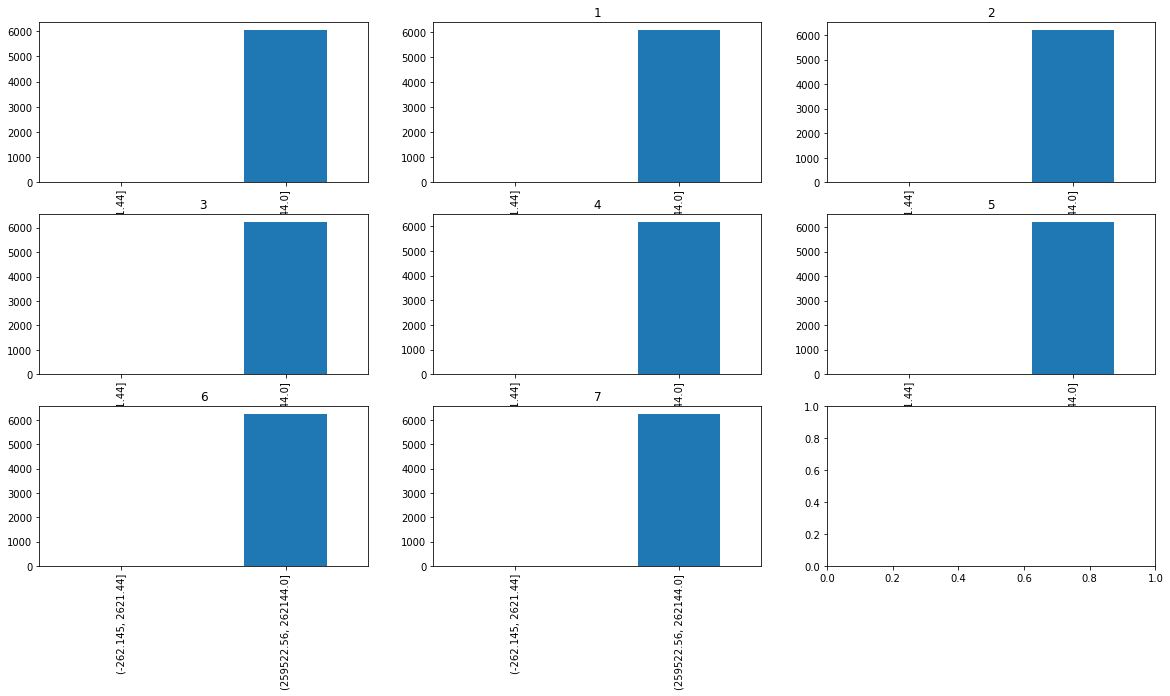

In [24]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))
for rank in df['Rank'].unique()[:8]:
    x = int(rank/3)
    y = rank%3
    tl = profile.GetIORequestDistribution(rank=rank)
    tl.plot(kind='bar', title=rank, ax=axs[x][y])

### File summary of each file accessed by the Application

In [25]:
pp = pprint.PrettyPrinter(indent=1)
count =1
for file in df['Filename'].unique()[:8]:
    if 'h5' in file:
        pp.pprint(profile.GetFileSummary(file,ext='h5'))
    else:
        if count == 1:
            count+=1
            pp.pprint(profile.GetFileSummary(file,ext='tfrecord',tf_record_features={
      'image/encoded': tf.io.FixedLenFeature((), dtype=tf.string, default_value=''),
      'image/source_id': tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/height': tf.io.FixedLenFeature((), tf.int64, default_value=1),
      'image/width': tf.io.FixedLenFeature((), tf.int64, default_value=1),
      'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(dtype=tf.float32),
      'image/object/class/label': tf.io.VarLenFeature(dtype=tf.int64),
      'image/object/class/text': tf.io.FixedLenFeature((), dtype=tf.string, default_value=''),
      'image/colorspace': tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/channels': tf.io.FixedLenFeature((), tf.int64, default_value=1),
      'image/format': tf.io.FixedLenFeature((), tf.string, default_value=''),
      'image/filename': tf.io.FixedLenFeature((), tf.string, default_value='')
  }))

{'ext': 'tfrecord',
 'filename': 'train-00263-of-01024',
 'io_size': 140498642,
 'io_time': 2.732300000000606,
 'path': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00263-of-01024',
 'size': 140498642,
 'special': <ParallelMapDataset shapes: {image/object/bbox/xmax: (None,), image/object/bbox/xmin: (None,), image/object/bbox/ymax: (None,), image/object/bbox/ymin: (None,), image/object/class/label: (None,), image/channels: (), image/colorspace: (), image/encoded: (), image/filename: (), image/format: (), image/height: (), image/object/class/text: (), image/source_id: (), image/width: ()}, types: {image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/object/class/label: tf.int64, image/channels: tf.int64, image/colorspace: tf.string, image/encoded: tf.string, image/filename: tf.string, image/format: tf.string, image/height: tf.int64, image/object/class/text: tf.string, i

In [26]:
profile.CreateChromeTimeline(location="/home/dhari/timeline/apps/imagenet", filename="imagenet_run5_p8.json")

[============================================================] 100.0% 49713 of 49713 Creating DXT Timeline 
[============================================================] 100.0% 984 of 984 Creating DXT Timeline 


{'traceEvents': [{'name': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00566-of-01024',
   'cat': 'X_POSIX',
   'ph': 'B',
   'ts': 193280400,
   'pid': 5,
   'tid': 0,
   'args': {'Module': 'X_POSIX',
    'Filename': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00566-of-01024',
    'Rank': 5,
    'Operation': 'read',
    'Segment': 0,
    'Offset': 0,
    'Length': 262144,
    'Start': 193.2804,
    'End': 193.3017}},
  {'name': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00412-of-01024',
   'cat': 'X_POSIX',
   'ph': 'B',
   'ts': 193284400,
   'pid': 5,
   'tid': 0,
   'args': {'Module': 'X_POSIX',
    'Filename': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/train-00412-of-01024',
    'Rank': 5,
    'Operation': 'read',
    'Segment': 0,
    'Offset': 0,
    'Length': 262144,
    'Start': 193.2844,
    'End': 193.3134}},
  {'name': '/projects/datascience/rzamora/data/imagenet/count.48.size.8m/trai